In [1]:
!conda install pandas numpy matplotlib plyotly


^C


In [11]:
import os
import json
import pandas as pd
import numpy as np
from scipy.ndimage import gaussian_filter1d

# ================= 配置区 =================
DATA_DIR = './data'
LABEL_MAP = {
    'others': 0,
    'Flipendo': 1,
    'WingardiumLeviosa': 2
}

# Arduino 设置 (必须严格匹配 Arduino 代码)
TARGET_LEN = 187       # 采样点数
TOTAL_FEATURES = TARGET_LEN * 3 

# 滤波系数 (必须匹配 Arduino 代码中的 ALPHA)
ALPHA = 0.2 

# ==========================================

wide_data_list = []

print(f"🚀 开始处理数据 (模式: m/s² -> G -> 去重力)...")

def simulate_high_pass_filter(data, alpha):
    """
    完全模拟 Arduino 上的低通+高通滤波逻辑
    data: shape (N, 3)
    """
    gravity = np.zeros(3) # 初始重力假设为 0 (或者取第一帧)
    # 为了更稳，可以用第一帧初始化重力
    gravity = data[0].copy()
    
    linear_acc = np.zeros_like(data)
    
    for i in range(len(data)):
        raw = data[i]
        
        # 1. 低通滤波提取重力 (模拟 Arduino)
        gravity = alpha * raw + (1 - alpha) * gravity
        
        # 2. 高通滤波移除重力
        linear_acc[i] = raw - gravity
        
    return linear_acc

for folder_name, label_id in LABEL_MAP.items():
    folder_path = os.path.join(DATA_DIR, folder_name)
    if not os.path.exists(folder_path): continue
        
    print(f"📂 处理类别: {folder_name} (Label={label_id})...")
    
    file_count = 0
    for filename in os.listdir(folder_path):
        if not filename.endswith('.json'): continue
        file_path = os.path.join(folder_path, filename)
        
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                data = json.load(f)
            
            if 'payload' in data and 'values' in data['payload']:
                values = data['payload']['values']
                # 原始数据 (N, 3)，单位 m/s²
                raw_data_ms2 = np.array(values, dtype=float) 
                
                # --- 1. 单位转换: m/s² -> G ---
                # Arduino 读数通常是 G，为了对齐，这里除以 9.8
                # 这样数据范围就会从 ~10.0 变成 ~1.0
                raw_data_g = raw_data_ms2 / 9.80665
                
                # --- 2. 模拟 Arduino 的去重力滤波器 ---
                # 这一步至关重要！它把包含重力的数据变成了“纯动作数据”
                # 结果应该在 0 附近波动
                acc_data = simulate_high_pass_filter(raw_data_g, ALPHA)

                # --- 4. 截断异常值 (Clipping) ---
                # 限制在 ±4G 范围内 (Arduino 量程)
                acc_data = np.clip(acc_data, -4.0, 4.0)

                # --- 5. 长度对齐 (Padding / Truncation) ---
                curr_len = acc_data.shape[0]
                if curr_len > TARGET_LEN:
                    # 取中间段 (通常动作在中间)
                    start = (curr_len - TARGET_LEN) // 2
                    acc_data = acc_data[start : start+TARGET_LEN, :]
                elif curr_len < TARGET_LEN:
                    pad_len = TARGET_LEN - curr_len
                    zeros = np.zeros((pad_len, 3))
                    acc_data = np.vstack((acc_data, zeros))
                
                # 展平
                flat_values = acc_data.flatten().tolist()
                
                row_data = {'label': label_id}
                for i, val in enumerate(flat_values):
                    axis = ['x', 'y', 'z'][i % 3]
                    step = i // 3
                    col_name = f"{axis}{step}"
                    row_data[col_name] = val
                
                wide_data_list.append(row_data)
                file_count += 1
                
        except Exception as e:
            print(f"  ❌ 失败: {filename} {e}")

# 保存 CSV
if wide_data_list:
    df_final = pd.DataFrame(wide_data_list)
    
    # 补全列名确保对齐
    standard_cols = ['label']
    for i in range(TARGET_LEN):
        standard_cols.extend([f"x{i}", f"y{i}", f"z{i}"])
        
    # 重建 DataFrame
    df_final = pd.DataFrame(wide_data_list).reindex(columns=standard_cols, fill_value=0.0)
    
    # 确保 label 是整数
    df_final['label'] = df_final['label'].astype(int)

    output_file = 'data_calc_acc.csv'
    df_final.to_csv(output_file, index=False)
    
    print("-" * 30)
    print(f"✅ 处理完成！")
    print(f"样本数: {len(df_final)}")
    print(f"保存至: {output_file}")
    
    # 统计检查
    data_cols = df_final.iloc[:, 1:]
    print("\n📊 数据统计 (单位 G, 均值应接近 0):")
    print(f"Max: {data_cols.max().max():.4f}")
    print(f"Min: {data_cols.min().min():.4f}")
    print(f"Mean: {data_cols.mean().mean():.4f}") # 应该非常接近 0.0
else:
    print("❌ 未提取到数据")

🚀 开始处理数据 (模式: m/s² -> G -> 去重力)...
📂 处理类别: others (Label=0)...
📂 处理类别: Flipendo (Label=1)...
📂 处理类别: WingardiumLeviosa (Label=2)...
------------------------------
✅ 处理完成！
样本数: 900
保存至: data_calc_acc.csv

📊 数据统计 (单位 G, 均值应接近 0):
Max: 4.0000
Min: -4.0000
Mean: 0.0004


In [12]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np

# 1. 读取数据
csv_file = 'data_calc_acc.csv'
try:
    df = pd.read_csv(csv_file)
    print(f"数据加载成功: {len(df)} 样本")
except FileNotFoundError:
    print("找不到文件")
    exit()

# 2. 配置
LABEL_MAP_INV = {
    0: 'Others',
    1: 'Flipendo',
    2: 'Wingardium'
}
SAMPLES_TO_SHOW = 1 # 每个类别看几个样本

# 3. 创建子图 (每个类别一列)
fig = make_subplots(
    rows=len(LABEL_MAP_INV), cols=1,
    subplot_titles=[v for k, v in LABEL_MAP_INV.items()],
    vertical_spacing=0.1
)

print("正在生成波形图...")

for i, (label_id, label_name) in enumerate(LABEL_MAP_INV.items()):
    class_df = df[df['label'] == label_id]
    if len(class_df) == 0: continue

    # 随机抽样
    sample_row = class_df.sample(1).iloc[0]
    
    # 提取数据
    raw_values = sample_row.drop('label').values
    # 确保是 3 的倍数并 reshape
    valid_len = len(raw_values) - (len(raw_values) % 3)
    waveform = raw_values[:valid_len].reshape(-1, 3)
    
    # X 轴 (红色)
    fig.add_trace(go.Scatter(
        y=waveform[:, 0], mode='lines', name='Acc X',
        line=dict(color='red', width=1.5), opacity=0.8,
        showlegend=(i==0) # 只在第一张图显示图例
    ), row=i+1, col=1)

    # Y 轴 (绿色)
    fig.add_trace(go.Scatter(
        y=waveform[:, 1], mode='lines', name='Acc Y',
        line=dict(color='green', width=1.5), opacity=0.8,
        showlegend=(i==0)
    ), row=i+1, col=1)

    # Z 轴 (蓝色)
    fig.add_trace(go.Scatter(
        y=waveform[:, 2], mode='lines', name='Acc Z',
        line=dict(color='blue', width=1.5), opacity=0.8,
        showlegend=(i==0)
    ), row=i+1, col=1)

# 4. 布局调整
fig.update_layout(
    height=900, width=1000,
    title_text="加速度时间序列 (波形图)",
    template="plotly_dark"
)

# 锁定 Y 轴范围，方便对比 (Arduino 量程通常是 +-4G)
fig.update_yaxes(range=[-3, 3], title_text="加速度 (G)")
fig.update_xaxes(title_text="时间步 (Time Steps)")

fig.show()

数据加载成功: 900 样本
正在生成波形图...


In [13]:
import numpy as np
from scipy.interpolate import interp1d
from tensorflow.keras.utils import Sequence

class IMUDataGenerator(Sequence):
    def __init__(self, X, y, batch_size=32, shuffle=True, input_shape=(187, 3), augment=True):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.input_shape = input_shape
        self.time_steps = input_shape[0]
        self.channels = input_shape[1]
        self.augment = augment
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.X) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        batch_X_raw = self.X[indexes]
        batch_y = self.y[indexes]

        if self.augment:
            batch_X = self.__data_augmentation(batch_X_raw)
        else:
            batch_X = batch_X_raw.reshape(-1, self.time_steps, self.channels)

        return np.array(batch_X), np.array(batch_y)

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.X))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_augmentation(self, X_batch):
        # Reshape to (Batch, Time, Channels)
        X_batch = X_batch.reshape(-1, self.time_steps, self.channels)
        X_aug = np.empty_like(X_batch)

        for i in range(X_batch.shape[0]):
            sample = X_batch[i].copy()
            
            # --- 核心增强逻辑 ---
            # 1. 模拟“握持方向旋转 90 度” (Permutation)
            # 这解决了“上下变成了 y 轴或 x 轴”的问题
            if np.random.rand() < 0.3:
                idx = np.random.permutation(self.channels)
                sample = sample[:, idx]

            # 2. 模拟“握持方向拿反了” (Channel Flip)
            if np.random.rand() < 0.3:
                sample = self._channel_flip(sample)

            # 3. 模拟“握持姿势歪了” (Spatial Rotation)
            # 解决了“稍微拿斜了 30 度”导致能量分散到两个轴上的问题
            if np.random.rand() < 0.4:
                sample = self._spatial_affine(sample)

            # 4. 模拟“用力大小不同” (Scaling)
            if np.random.rand() < 0.5:
                factor = np.random.normal(1.0, 0.1)
                sample *= factor

            # 5. 模拟“动作快慢不一” (Time Warping)
            if np.random.rand() < 0.3:
                sample = self._time_warp(sample)

            # 6. 模拟“手抖/传感器底噪” (Jitter)
            if np.random.rand() < 0.5:
                noise = np.random.normal(0, 0.05, sample.shape)
                sample += noise
            
            X_aug[i] = sample

        return X_aug

    # --- 增强的具体实现 ---
    # 连续弹性变形 (Continuous) Time Warping 生成一条随机波动的“时间曲线”，对整个时间轴进行非线性的挤压和拉伸。
    def _time_warp(self, x, sigma=0.2):
        tt = np.arange(self.time_steps)
        noise = np.random.normal(loc=0, scale=sigma, size=(self.time_steps,))
        tt_new = tt + np.cumsum(noise)
        tt_new = (tt_new - tt_new.min()) / (tt_new.max() - tt_new.min()) * (self.time_steps - 1)
        
        x_new = np.zeros_like(x)
        for i in range(self.channels):
            f = interp1d(tt_new, x[:, i], kind='linear', fill_value="extrapolate")
            x_new[:, i] = f(tt)
        return x_new

    def _channel_flip(self, x):
        # 随机选择某些轴乘以 -1
        # choice: 生成一个 shape 为 (3,) 的向量，包含 1 或 -1
        augment_vector = np.random.choice([1.0, -1.0], size=self.channels)
        return x * augment_vector

    def _spatial_affine(self, x):
        # 使用全 3D 旋转矩阵，模拟任意角度的倾斜握持
        
        # 随机生成三个轴的旋转角度 (-30 ~ +30 度)
        ang_x = np.deg2rad(np.random.uniform(-30, 30))
        ang_y = np.deg2rad(np.random.uniform(-30, 30))
        ang_z = np.deg2rad(np.random.uniform(-30, 30))

        # 构建旋转矩阵 (简化版，叠加三个单轴旋转)
        # 1. 绕 X 轴
        cx, sx = np.cos(ang_x), np.sin(ang_x)
        Rx = np.array([[1, 0, 0], [0, cx, -sx], [0, sx, cx]])
        # 2. 绕 Y 轴
        cy, sy = np.cos(ang_y), np.sin(ang_y)
        Ry = np.array([[cy, 0, sy], [0, 1, 0], [-sy, 0, cy]])
        # 3. 绕 Z 轴
        cz, sz = np.cos(ang_z), np.sin(ang_z)
        Rz = np.array([[cz, -sz, 0], [sz, cz, 0], [0, 0, 1]])
        # 组合旋转 R = Rz * Ry * Rx
        R = np.dot(Rz, np.dot(Ry, Rx))
        x = np.dot(x, R)

        return x

In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

csv_file = 'data_calc_acc.csv' # 使用你之前生成的无重力数据
try:
    df = pd.read_csv(csv_file)
    print(f"✅ 数据加载成功，总样本数: {len(df)}")
except FileNotFoundError:
    print("❌ 找不到文件")
    exit()

# 提取特征和标签
if 'filename' in df.columns:
    X = df.drop(['label', 'filename'], axis=1)
else:
    X = df.drop(['label'], axis=1)
y = df['label']

# 划分训练集和验证集
X_train, X_val, y_train, y_val = train_test_split(
    X.values, y.values, # 转为 numpy array
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print(f"数据形状: {X_train.shape} (样本数, 特征数)")

# ==========================================
# 3. 实例化生成器 (连接数据与模型)
# ==========================================
BATCH_SIZE = 16

train_gen = IMUDataGenerator(
    X_train, 
    y_train, 
    batch_size=BATCH_SIZE, 
    augment=True
)

val_gen = IMUDataGenerator(
    X_val, 
    y_val, 
    batch_size=BATCH_SIZE, 
    augment=False
)

print(f"shape of train_gen: {train_gen.__getitem__(0)[0].shape}")

✅ 数据加载成功，总样本数: 900
数据形状: (720, 561) (样本数, 特征数)
shape of train_gen: (16, 187, 3)


In [15]:
import tensorflow as tf

INPUT_POINTS = 187   # 采样点数
CHANNELS = 3         # x, y, z
INPUT_SHAPE = INPUT_POINTS * CHANNELS # 561
EMBEDDING_DIM = 16   # 最终输出的特征维度 (Federated Learning 传输用)
NUM_CLASSES = 3      # Others, Flipendo, Wingardium

modelNN = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(INPUT_POINTS, CHANNELS)),
    # 输入: (187, 3) -> 输出: (187/4 = 47, 16)
    tf.keras.layers.Conv1D(filters=16, kernel_size=16, strides=4, activation='relu', padding='same'),
    # (47, 16) ->  (11, 16) Pool=4: 47/4 ≈ 11
    tf.keras.layers.MaxPooling1D(pool_size=4),
    # 11 * 16 = 176
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(EMBEDDING_DIM, activation='relu', name='embedding_layer'),
    tf.keras.layers.Dropout(0.2),

    # 注意：导出给 Arduino 时，这一层会被切掉！
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

modelNN.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 47, 16)            784       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 11, 16)           0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 176)               0         
                                                                 
 embedding_layer (Dense)     (None, 16)                2832      
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 3)                 51        
                                                      

开始训练...
Epoch 1/500
45/45 [==============================] - 1s 6ms/step - loss: 1.0542 - accuracy: 0.5042 - val_loss: 0.9049 - val_accuracy: 0.8636 - lr: 0.0010
Epoch 2/500
45/45 [==============================] - 0s 4ms/step - loss: 0.8347 - accuracy: 0.7486 - val_loss: 0.5539 - val_accuracy: 0.9602 - lr: 0.0010
Epoch 3/500
45/45 [==============================] - 0s 5ms/step - loss: 0.6118 - accuracy: 0.8597 - val_loss: 0.3096 - val_accuracy: 0.9659 - lr: 0.0010
Epoch 4/500
45/45 [==============================] - 0s 4ms/step - loss: 0.4490 - accuracy: 0.8681 - val_loss: 0.1891 - val_accuracy: 0.9716 - lr: 0.0010
Epoch 5/500
45/45 [==============================] - 0s 5ms/step - loss: 0.3689 - accuracy: 0.8903 - val_loss: 0.1509 - val_accuracy: 0.9773 - lr: 0.0010
Epoch 6/500
45/45 [==============================] - 0s 4ms/step - loss: 0.3318 - accuracy: 0.8847 - val_loss: 0.1205 - val_accuracy: 0.9773 - lr: 0.0010
Epoch 7/500
45/45 [==============================] - 0s 5ms/step - l

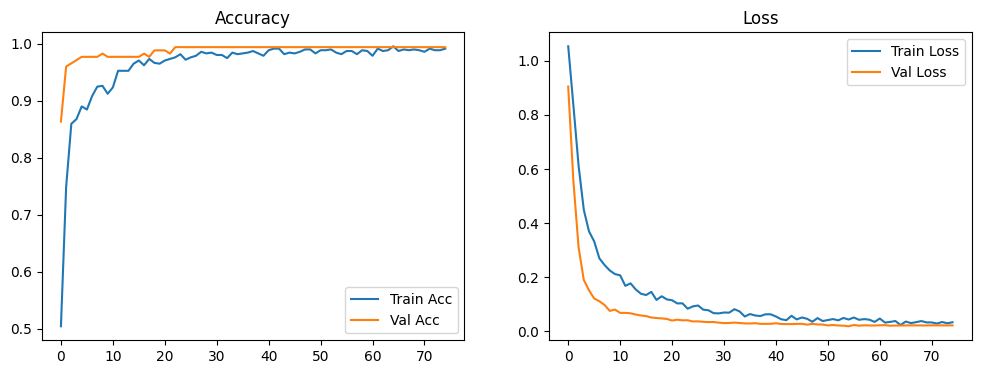

In [16]:
from matplotlib import pyplot as plt
import tensorflow as tf

optimizer = tf.keras.optimizers.AdamW(
    learning_rate=0.001, 
    weight_decay=0.004
)

modelNN.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy', # 标签是整数(0,1,2)所以用 sparse
    metrics=['accuracy']
)

# ---------------- 4. 训练回调函数 ----------------
callbacks = [
    # 早停：如果验证集 loss 20次没有下降，就停止训练
    tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True, monitor='val_loss'),
    # 学习率调整：如果 loss 震荡，自动减小学习率
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)
]

print("开始训练...")
history = modelNN.fit(
    train_gen,
    validation_data=val_gen,
    epochs=500,          # 最大轮数
    callbacks=callbacks,
)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show()

In [17]:
import tensorflow as tf

# 1. 切头
feature_extractor = tf.keras.models.Model(
    inputs=modelNN.inputs, 
    outputs=modelNN.get_layer('embedding_layer').output
)

# 2. 转 TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(feature_extractor)
tflite_model = converter.convert()

# 3. 生成最纯净的 net.h
def tflite_to_c_header(tflite_data, array_name='g_model'):
    c_str = "#ifndef NET_H\n#define NET_H\n\n"
    c_str += f"// TFLite Model\n"
    c_str += f"const unsigned char {array_name}[] = {{\n"
    for i, val in enumerate(tflite_data):
        c_str += f"0x{val:02x}, "
        if (i + 1) % 12 == 0: c_str += "\n"
    c_str += "};\n"
    c_str += f"const int {array_name}_len = {len(tflite_data)};\n"
    c_str += "\n#endif // NET_H\n"
    return c_str

with open('net.h', 'w') as f:
    f.write(tflite_to_c_header(tflite_model))

INFO:tensorflow:Assets written to: C:\Users\19073\AppData\Local\Temp\tmppm015vbd\assets


INFO:tensorflow:Assets written to: C:\Users\19073\AppData\Local\Temp\tmppm015vbd\assets
